In [ ]:
####################################################################################
#       kbox.ai - Khalil Zarifsadr / last update: 4/15/2021                        #
#       Model A: ROP Prediction with 95% Prediction Interval                       #
#                                                                                  #
####################################################################################

# importing requird libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import dill as pickle
import xgboost as xgb
import math
# making numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)
# printoptions determine the way floating point numbers, arrays, and other Numpy objects are displayed

In [ ]:
# importing other requird libraries
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
####################################################################################
#                                                                                  #
#                                IMPORTING DATA                                    #
#                                                                                  #
####################################################################################

# uploading files from google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/AI PROJECT"
# importing data from google drive
data1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI PROJECT/10795.csv")
data2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI PROJECT/10796.csv")
data3 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI PROJECT/10797.csv")
data4 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI PROJECT/10798.csv")
data5 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI PROJECT/10799.csv")

 10795.csv  'bell canyon'	  optimizationDataFolder   T9102.csv
 10796.csv  'bone spring'	 'second bone spring'	  'third bone spring'
 10797.csv  'brushy canyon'	 'surface to castile'	  'wolfcamp a'
 10798.csv   castile		  T9099.csv		  'xgboost model'
 10799.csv  'cherry canyon'	  T9100.csv
 avalon     'first bone spring'   T9101.csv


In [ ]:
####################################################################################
#                                                                                  #
#                                  DATA WRANGLING                                  #
#                                                                                  #
####################################################################################

# updating bit size
bitsize_sur= 12.25
bitsize_int= 8.75
bitsize_lat= 6.125

In [ ]:
# updating bitsize for surface, intermediate, and production. we may instead update the Bit Diameter initially in the data frame as an input

data1.loc[:2514,('Bit Diameter')] = np.array(bitsize_sur) # surface section at 2650' = index 2514
data1.loc[2514:9025,('Bit Diameter')] = np.array(bitsize_int) # intermediate section at 9161' = index 9025
data1.loc[9025:,('Bit Diameter')] = np.array(bitsize_lat)

data2.loc[:2451,('Bit Diameter')] = np.array(bitsize_sur) # surface section at 2650' = index 2451
data2.loc[2451:8882,('Bit Diameter')] = np.array(bitsize_int) # intermediate section at 9083' = index 8882
data2.loc[8882:,('Bit Diameter')] = np.array(bitsize_lat)

data3.loc[:2261,('Bit Diameter')] = np.array(bitsize_sur) # surface section at 2633' = index 2261
data3.loc[2261:8797,('Bit Diameter')] = np.array(bitsize_int) # intermediate section at 9179' = index 8797
data3.loc[8797:,('Bit Diameter')] = np.array(bitsize_lat)

data4.loc[:2293,('Bit Diameter')] = np.array(bitsize_sur) # surface section at 2627' = index 2293
data4.loc[2293:8750,('Bit Diameter')] = np.array(bitsize_int) # intermediate section at 9085' = index 8750
data4.loc[8750:,('Bit Diameter')] = np.array(bitsize_lat)

data5.loc[:2462,('Bit Diameter')] = np.array(bitsize_sur) # surface section at 2654' = index 2462
data5.loc[2462:8929,('Bit Diameter')] = np.array(bitsize_int) # intermediate section at 9121' = index 8929
data5.loc[8929:,('Bit Diameter')] = np.array(bitsize_lat)

In [ ]:
# building a data frame
frames = [data1,data2,data3,data5] #we keep data4 for validation as a new well to be drilled in future
data = pd.concat(frames) # concatenate data frames to the bottom of each other

# number of rows and columns
#data.shape

In [ ]:
# choosing features to be used initially in the model
data = data[['Weight on Bit','Top Drive RPM','Top Drive Torque (ft-lbs)','Differential Pressure','Flow In',
             'ROP Depth/Hour','Pump Pressure','MWD Gamma (API)','depth','Bit Diameter']]
# renaming columns
data.rename(columns={'Weight on Bit':'WOB','Top Drive RPM':'RPM','Top Drive Torque (ft-lbs)':'TORQUE',
                     'Differential Pressure':'DIFF P','ROP Depth/Hour':'ROP','MWD Gamma (API)':'GAMMA',
                     'Pump Pressure':'PUMP P','Flow In':'FLOW IN','depth':'DEPTH','Bit Diameter':'BIT'}, inplace= True)

#data.head()
#data.tail()
#data.shape

In [ ]:
# cleaning the data
data.isna().sum()
data = data.dropna()

In [ ]:
# creating pairplot to see the distribution of the data
#df = data[['WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P','GAMMA','ROP']]
#sns.pairplot(df, diag_kind='auto')

In [ ]:
####################################################################################
#                                                                                  #
#                            EXPLORATORY DATA ANALYSIS                             #
#                                                                                  #
####################################################################################

#data.describe().transpose() 

In [ ]:
#corr = data[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P']].corr()
#corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# removing outliers from data with two techniques: 1: Inter Quartile Range (IQR) 
#start with the label (ROP) and later continue with features
data = data[data['ROP'].between(data['ROP'].quantile(0.0016), data['ROP'].quantile(0.999))]
data = data[data['RPM'].between(data['RPM'].quantile(0.008), data['RPM'].quantile(0.999))]
#data = data[data['WOB'].between(data['WOB'].quantile(0.001), data['WOB'].quantile(0.999))]
#data = data[data['PUMP P'].between(data['PUMP P'].quantile(0.001), data['PUMP P'].quantile(0.999))]
#data = data[data['DIFF P'].between(data['DIFF P'].quantile(0.001), data['DIFF P'].quantile(0.999))]
#data = data[data['FLOW IN'].between(data['FLOW IN'].quantile(0.001), data['FLOW IN'].quantile(0.999))]
#data = data[data['TORQUE'].between(data['TORQUE'].quantile(0.001), data['TORQUE'].quantile(0.999))]

#data.describe().transpose() 

In [ ]:
#corr = data[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P']].corr()
#corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# removing outliers from data with two techniques: 2: Data Smoothing with smoothing factor alpha 0<α≤1.
data['ROP'] = data['ROP'].ewm(alpha = 0.9).mean()
data['WOB'] = data['WOB'].ewm(alpha = 0.9).mean()
data['RPM'] = data['RPM'].ewm(alpha = 0.9).mean()
data['PUMP P'] = data['PUMP P'].ewm(alpha = 0.9).mean()
data['DIFF P'] = data['DIFF P'].ewm(alpha = 0.9).mean()
data['TORQUE'] = data['TORQUE'].ewm(alpha = 0.9).mean()
data['FLOW IN'] = data['FLOW IN'].ewm(alpha = 0.9).mean()
data['GAMMA'] = data['GAMMA'].ewm(alpha = 0.9).mean()

#data.describe().transpose() 

In [ ]:
# plotting correlation coefficient between variables
#corr = data[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P']].corr()
#corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# making a pairplot 
#df = train_data[['WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P','ROP']]
#sns.pairplot(df, diag_kind='auto')

In [ ]:
####################################################################################
#                                                                                  #
#                                MACHINE LEARNING                                  #
#                                                                                  #
####################################################################################

# splitting the dataset into a training set and a test set. test set for the final evaluation of the model. 
# setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time you run the code.
train_data = data[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P','DEPTH','BIT']].sample(frac=0.80, random_state=0)
test_data = data[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P','DEPTH','BIT']].drop(train_data.index)

In [ ]:
# splitting features from labels
# separating the target value, the "label", from the features:
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('ROP')
test_labels = test_features.pop('ROP')

In [ ]:
####################################################################################
#                         XGBoost Hyperparameter Tuning                            #
####################################################################################

# hyperparameters tuning in a pipeline
my_pipeline = Pipeline([('xgb_st_scalar', StandardScaler()), ('xgbr', xgb.XGBRegressor(objective='reg:squarederror'))])

param_grid = {
    "xgbr__max_depth": np.arange(3,11,1),
    "xgbr__learning_rate": np.arange(0.03,0.1,0.01),
    "xgbr__n_estimator": np.arange(125,250,25),
    "xgbr__gamma": np.arange(3,11,1),
    "xgbr__min_child_weight": np.arange(1,7,2),
    "xgbr__colsample_bytree": np.arange(0.5,1,0.05),
    "xgbr__colsample_bylevel": np.arange(0.5,1,0.05),
    "xgbr__colsample_bynode": np.arange(0.5,0.9,0.05)
    }

search_cv = RandomizedSearchCV(estimator=my_pipeline, param_distributions=param_grid,cv=4) 
# activate when tuning
#search_cv.fit(train_features, train_labels)

In [ ]:
# the best tuning parameters are
# activate when tuning
#search_cv.best_params_

In [ ]:
# activate when tuning
#max_depth = search_cv.best_params_['xgbr__max_depth']
#learning_rate = search_cv.best_params_['xgbr__learning_rate']
#n_estimators = search_cv.best_params_['xgbr__n_estimator']
#gamma = search_cv.best_params_['xgbr__gamma']
#min_child_weight = search_cv.best_params_['xgbr__min_child_weight']
#colsample_bylevel = search_cv.best_params_['xgbr__colsample_bylevel']
#colsample_bynode = search_cv.best_params_['xgbr__colsample_bynode']
#colsample_bytree = search_cv.best_params_['xgbr__colsample_bytree']

# copying the closest best tuning parameters here and manually continue tunning step by step  
colsample_bylevel = 0.85
colsample_bynode = 0.65
colsample_bytree = 0.9
gamma = 9
learning_rate = 0.03
max_depth = 9
min_child_weight = 1
n_estimators = 175

In [ ]:
####################################################################################
#                          XGBoost Prediction Interval                             #
####################################################################################

# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
  def _log_cosh_quantile(y_true, y_pred):
    error = y_pred - y_true
    error = np.where(error < 0, alpha * error, (1 - alpha) * error)
    grad = np.tanh(error)
    hess = 1 / np.cosh(error)**2
    return grad, hess
  return _log_cosh_quantile

#https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
#Five Regression Loss Functions All Machine Learners Should Know
#https://towardsdatascience.com/confidence-intervals-for-xgboost-cac2955a8fde
#Confidence intervals for XGBoost

In [ ]:
# defining alpha between 0.001 and 0.999 depends on the desired confidence interval 
alpha = 0.975

In [ ]:
# upper prediction of ROP with XGBoost using the loss function
xgb_model_u = xgb.XGBRegressor(objective=log_cosh_quantile(alpha),
                               max_depth = max_depth, learning_rate = learning_rate, n_estimators = n_estimators, 
                               gamma = gamma, colsample_bytree = colsample_bytree, colsample_bylevel = colsample_bylevel, 
                               colsample_bynode = colsample_bynode, min_child_weight = min_child_weight, verbosity = 0)
                        
xgb_model_u.fit(train_features,train_labels)
test_upper_predictions = xgb_model_u.predict(test_features)

# lower prediction of ROP with XGBoost using the loss function
xgb_model_l = xgb.XGBRegressor(objective=log_cosh_quantile(1-alpha),
                               max_depth = max_depth, learning_rate = learning_rate-0.01, n_estimators = n_estimators, 
                               gamma = gamma, colsample_bytree = colsample_bytree, colsample_bylevel = colsample_bylevel, 
                               colsample_bynode = colsample_bynode, min_child_weight = min_child_weight, verbosity = 0)
                         
xgb_model_l.fit(train_features,train_labels)
test_lower_predictions = xgb_model_l.predict(test_features)

# https://xgboost.readthedocs.io/en/latest/parameter.html

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
####################################################################################
#                         XGBoost Single Value Prediction                          #
####################################################################################

# single value prediction of ROP with XGBoost
xgb_model = xgb.XGBRegressor(max_depth = max_depth, learning_rate = learning_rate, n_estimators = n_estimators, 
                             gamma = gamma, colsample_bytree = colsample_bytree, colsample_bylevel = colsample_bylevel, 
                             colsample_bynode = colsample_bynode, min_child_weight = min_child_weight , verbosity = 0)

xgb_model.fit(train_features,train_labels)
test_predictions = xgb_model.predict(test_features)

# https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# checking the model training score after training
score = xgb_model.score(train_features,train_labels)  
print("Training score: ", score)

Training score:  0.9423140811163128


In [ ]:
####################################################################################
#                                                                                  #
#                                EVALUATION METRICS                                #
#                                                                                  #
####################################################################################

# different evaluation metrics including MSE, RMSE, R2, and MAE
r2 = r2_score(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)
mse = mean_squared_error(test_labels, test_predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_labels, test_predictions)

# defining prediction interval accuracy (PIA): 
ROP = pd.DataFrame(test_labels, columns=['ROP'])
ROPM = pd.DataFrame(test_predictions, columns=['ROPM'])
ROPL = pd.DataFrame(test_lower_predictions, columns=['ROPL'])
ROPU = pd.DataFrame(test_upper_predictions, columns=['ROPU'])

dataFrame = pd.concat([ROP, ROPL.set_index(ROP.index)], axis=1)
dataFrame = pd.concat([dataFrame, ROPM.set_index(ROP.index)], axis=1)
dataFrame = pd.concat([dataFrame, ROPU.set_index(ROP.index)], axis=1)
pia = len(dataFrame.loc[(dataFrame['ROPL'] < dataFrame['ROP']) & (dataFrame['ROP'] < dataFrame['ROPU'])])/len(dataFrame)*100
piam = len(dataFrame.loc[(dataFrame['ROPL'] < dataFrame['ROPM']) & (dataFrame['ROPM'] < dataFrame['ROPU'])])/len(dataFrame)*100
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)
print("MAPE: %.2f" % mape)
print("PIA (Prediction Interval Accuracy): %.2f" % pia)
print("PIA (Theoretical Prediction Interval Accuracy): %.2f" % piam)

R2: 0.83
MAE: 22.56
MAPE: 16.86
PIA (Prediction Interval Accuracy): 96.51
PIA (Theoretical Prediction Interval Accuracy): 98.84


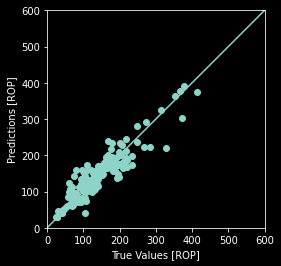

In [ ]:
# visualization of the model:
with plt.style.context(('dark_background')):
  a = plt.axes(aspect='equal')
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [ROP]')
  plt.ylabel('Predictions [ROP]')
  lims = [0, 600]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

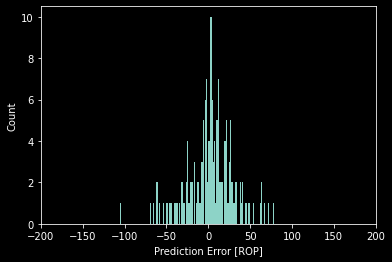

In [ ]:
# error distribution:
error = test_predictions - test_labels
with plt.style.context(('dark_background')):
  plt.hist(error, bins=300)
  plt.xlim(-200,200)
  plt.xlabel('Prediction Error [ROP]')
  _ = plt.ylabel('Count')

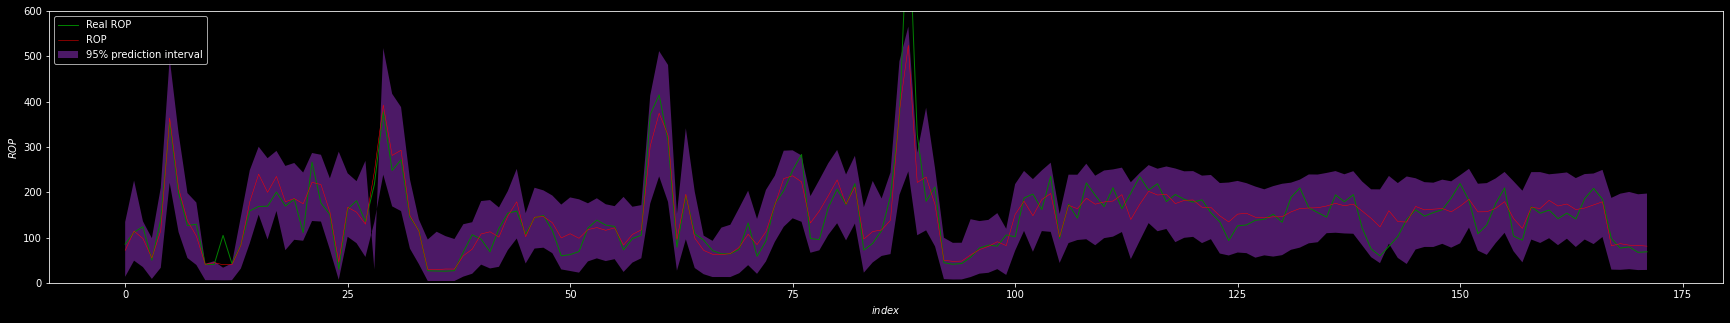

In [ ]:
####################################################################################
#                                                                                  #
#                        VISUALIZATION OF THE RESULTS                              #
#                                                                                  #
####################################################################################

max_length = 10000

with plt.style.context(('dark_background')):
  plt.figure(figsize=(30,5))
  plt.plot(list(test_labels[:max_length]),linewidth=1,color='green',label=u'Real ROP')
  plt.plot(list(test_predictions[:max_length]),linewidth=0.5, color='red', label='ROP')
  #plt.plot(test_upper_predictions[:max_length], linewidth=0.5, color='darkorchid', label="Upper ROP")
  #plt.plot(test_lower_predictions[:max_length], linewidth=0.5, color='darkorchid', label="Lower ROP")
  index = np.array(range(0, len(test_upper_predictions[:max_length])))
  plt.fill(np.concatenate([index, index[::-1]]),
             np.concatenate([test_upper_predictions[:max_length], test_lower_predictions[:max_length][::-1]]),
             alpha=.5, fc='darkorchid', ec='None', label='95% prediction interval')
  plt.ylim(0,600)
  plt.xlabel('$index$')
  plt.ylabel('$ROP$')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
####################################################################################
#                                                                                  #
#                          SAVING THE MODEL to CLOUD                               #
#                                                                                  #
####################################################################################

# If you like the model, save the entire model for later use
pickle.dump(xgb_model, open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model.pickle.dat", "wb"))
pickle.dump(xgb_model_u, open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model_u.pickle.dat", "wb"))
pickle.dump(xgb_model_l, open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model_l.pickle.dat", "wb"))

In [ ]:

#
#
#
#
#
####################################################################################
#                                                                                  #
#                     VALIDATION OF THE MODEL ON A NEW DATASET                     #
#                                                                                  #
####################################################################################

# validation data set - use data4 for validation as a new well
data_validation = data4[['Weight on Bit','Top Drive RPM','Top Drive Torque (ft-lbs)','Differential Pressure','Flow In'
             ,'ROP Depth/Hour','Pump Pressure','MWD Gamma (API)','depth','Bit Diameter']]
data_validation = pd.DataFrame(data_validation)

# renaming columns
data_validation.rename(columns={'Weight on Bit':'WOB','Top Drive RPM':'RPM','Top Drive Torque (ft-lbs)':'TORQUE',
                     'Differential Pressure':'DIFF P','ROP Depth/Hour':'ROP','MWD Gamma (API)':'GAMMA',
                     'Pump Pressure':'PUMP P', 'Flow In':'FLOW IN','depth':'DEPTH','Bit Diameter':'BIT'}, inplace= True)

In [ ]:
data_validation = data_validation[['ROP','WOB','RPM','TORQUE','DIFF P','FLOW IN','PUMP P','DEPTH','BIT']]
# splitting features from labels
validation_features = data_validation.copy()
validation_labels= validation_features.pop('ROP')

In [ ]:
# evaluating the model on the validation set:

# load model from the source file path
loaded_model = pickle.load(open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model.pickle.dat","rb"))
loaded_model_u = pickle.load(open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model_u.pickle.dat","rb"))
loaded_model_l = pickle.load(open("/content/drive/My Drive/Colab Notebooks/AI PROJECT/xgboost model/xgb_model_l.pickle.dat","rb"))
# making predictions 
validation_predictions = loaded_model.predict(validation_features)
validation_predictions_u = loaded_model_u.predict(validation_features)
validation_predictions_l = loaded_model_l.predict(validation_features)

In [ ]:
# rounding to the tens place
#validation_predictions_u = [round_up(n, -1) for n in validation_predictions_u]
#validation_predictions_l = [round_down(n, -1) for n in validation_predictions_l]

In [ ]:
# unifying detatypes to from float32 to float64 and assigning column name to the prediction values
ROP_P = pd.DataFrame(validation_predictions, dtype="float64", columns=['ROP_P'])
ROP_U = pd.DataFrame(validation_predictions_u, dtype="float64", columns=['ROP_U'])
ROP_U = ROP_U.ewm(span=2,adjust=False).mean() #exponentially weighted moving average for smoothing the prediction interval
ROP_L = pd.DataFrame(validation_predictions_l, dtype="float64", columns=['ROP_L'])
ROP_L = ROP_L.ewm(span=2,adjust=False).mean() #exponentially weighted moving average for smoothing the prediction interval

# setting matching indexes for both sets
data_frame = pd.concat([data_validation, ROP_P.set_index(data_validation.index)], axis=1)
data_frame = pd.concat([data_frame, ROP_U.set_index(data_validation.index)], axis=1)
data_frame = pd.concat([data_frame, ROP_L.set_index(data_validation.index)], axis=1)

# setting index on depth for visualization purpose
data_frame = data_frame.set_index('DEPTH')

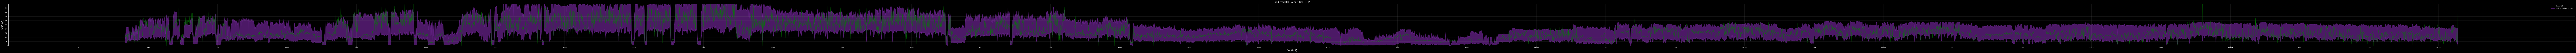

In [ ]:
# visualization of the model
DEPTH = data_validation['DEPTH']

with plt.style.context(('dark_background')):
  plt.figure(figsize=(300,5))
  plt.plot(data_frame['ROP'], linewidth=0.5, color='green', label="REAL ROP")
  #plt.plot(data_frame['ROP_P'], linewidth=0.5, color='g', label="PREDICTED ROP")
  plt.fill_between(DEPTH,data_frame['ROP_U'],data_frame['ROP_L'],alpha=0.5,color='darkorchid',label='95% prediction interval')
  plt.ylim(0,500)
  plt.xticks(np.arange(0, 17500, step=500))
  plt.yticks(np.arange(0, 500, step=50))
  plt.legend(loc='best')
  plt.xlabel('$Depth(ft)$',fontsize=15)
  plt.ylabel('$ROP(ft/h)$',fontsize=15)
  plt.grid(color='gray',linewidth=0.3)
  plt.title('Predicted ROP versus Real ROP',fontsize=15)
plt.show()

In [ ]:
# evaluation metrics
actual_rop = data_frame['ROP']
predicted_rop = ROP_P
mse = mean_squared_error(actual_rop,predicted_rop)
mae = mean_absolute_error(actual_rop,predicted_rop)
r2 = r2_score(actual_rop,predicted_rop)
# prediction interval accuracy
pia = len(data_frame.loc[(data_frame['ROP_L'] < data_frame['ROP']) & (data_frame['ROP'] < data_frame['ROP_U'])])/len(data_frame)*100
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: %.2f" % r2)
print("MAE: %.2f" % mae)
print("PIA (Prediction Interval Accuracy): %.2f" % pia)

R2: 0.57
MAE: 43.37
PIA (Prediction Interval Accuracy): 90.68
